In [89]:
# install
using Pkg

#Pkg.add("NLsolve")
Pkg.add("Optim")
Pkg.add("ForwardDiff")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
  [f6369f11] + ForwardDiff v0.10.7
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


A graph is usualy given by the list of links [(source, target), ...]. However, for the particular type of graph here, chains of nodes are considered. So the graph is given by chains of nodes: [[A1, A2, ...], ...].

In [ ]:
using Plots

In [90]:
using(ForwardDiff)

In [214]:
graph = [["074559265", "033293546", "177194634", "132327031", "05942608X", "147936594",
        "194946746", "20308523X", "160289750", "103659625", "103664262", "07456501X",
        "074559192", "074576127", "113270321", "123899249", "122925262", "121644545",
        "122935314", "13235103X", "149658192", "149531125", "151099103", "168078465",
        "17817310X", "18105938X", "181232529", "195092317", "202363856"],
    ["069862753", "033922020", "185417396", "185923089", "161170161", "188021574",
        "188160396", "188705945", "189504048", "189565624", "189997680", "190237201",
        "06986263X", "074589644", "076964361", "076694348", "076969576", "083593217",
        "110189159", "129545279"], ["112512380", "109209265", "185124100", "180818260",
        "185775926", "185887015", "187849390", "18786425X", "188021574", "112508901"],
    ["129545678", "129545279", "140093052", "154959588", "155289756", "176736999",
        "177538619", "179791338", "177523824", "195092317"],
    ["177539135", "177538619", "200874586", "241318939"],
    ["074576127", "168078465", "181232529"], ["188160396", "236926446"]];

In [126]:
graph = [["one", "two", "three"],
         ["two", "four", "five"]];

In [215]:
nodes = Set(n for ch in graph for n in ch);
println("#nodes: ", length(nodes))
println("#chains: ", length(graph))

#nodes: 70
#chains: 7


In [236]:
nodes_index = Dict(n=>k for (k, n) in enumerate(nodes));
N = length(nodes_index)
coords = vcat([[3*cos(k*2*pi/N) 3*sin(k*2*pi/N)] for k in 1:N]...)

70×2 Array{Float64,2}:
 2.98792   0.268918   
 2.95179   0.535671   
 2.89189   0.798111   
 2.8087    1.05412    
 2.70291   1.30165    
 2.57535   1.5387     
 2.42705   1.76336    
 2.25921   1.97382    
 2.07319   2.16838    
 1.87047   2.34549    
 1.65269   2.50372    
 1.42161   2.64179    
 1.17908   2.75858    
 ⋮                    
 1.65269  -2.50372    
 1.87047  -2.34549    
 2.07319  -2.16838    
 2.25921  -1.97382    
 2.42705  -1.76336    
 2.57535  -1.5387     
 2.70291  -1.30165    
 2.8087   -1.05412    
 2.89189  -0.798111   
 2.95179  -0.535671   
 2.98792  -0.268918   
 3.0      -7.34788e-16

Next we need a function which compute the system energy (and the forces?) for a given graph and a list of nodes coordinates. Folowing classical approach [Fruchterman and Reingold 1991](http://www.mathe2.uni-bayreuth.de/axel/papers/reingold:graph_drawing_by_force_directed_placement.pdf) there is an attractive force -between linked nodes- and repulsive forces between every nodes. In addition, here we want a torque at each node in a chain to rigidify the line. Maybe, a global gravity field would be required to densify the graph (keep disconected parts). 

$$
f_{attractive} = d^2/k \\
f_{repulsive} = -k^2/d
$$

In [217]:
coords

70×2 Array{Float64,2}:
 0.854739   0.866378 
 0.0419924  0.143998 
 0.0233209  0.424956 
 0.694477   0.6639   
 0.110073   0.834298 
 0.739879   0.788624 
 0.534901   0.144859 
 0.127812   0.470448 
 0.142576   0.498268 
 0.477738   0.112229 
 0.0536112  0.805004 
 0.414631   0.121816 
 0.548176   0.882847 
 ⋮                   
 0.396586   0.460641 
 0.961782   0.341588 
 0.878201   0.873318 
 0.42222    0.0770097
 0.105859   0.409078 
 0.146886   0.051248 
 0.418328   0.545573 
 0.166959   0.185402 
 0.771641   0.0069368
 0.702356   0.0754392
 0.0939552  0.103158 
 0.864095   0.663978 

In [130]:
using(Test)

In [131]:
"""Compute the square distance between two points

    x is a 2xn_dim array
"""
function squared_distance(pair)
    d = sum((pair[2, :] .- pair[1, :]).^2)
    end;

@test squared_distance([[1 0]; [0 1]]) == 2

Test Passed

In [132]:
coords[[2, 5], :]

2×2 Array{Float64,2}:
 0.68838   0.604315
 0.262616  0.092693

In [167]:
const k = .1 # whatever the unit

function attractive_energy(pair)
    d2 = squared_distance(pair)
    E = d2/k
    end;

function repulsive_energy(pair)
    d = sqrt( squared_distance(pair) )
    E = k^2 / d
    end;

#println( attractive_energy(nodes["033293546"], nodes["177194634"]) )
#println( repulsive_energy(nodes["033293546"], nodes["177194634"]) )

test http://www.juliadiff.org/ForwardDiff.jl/stable/

The torque will be function of the angle formed between 3 ordered nodes. 

In [168]:
attractive_energy(coords[[2, 4], :])

2.3283834921138826

In [169]:
ForwardDiff.gradient(repulsive_energy, coords[[2, 4], :])

2×2 Array{Float64,2}:
  0.00963457  -0.0418536
 -0.00963457   0.0418536

In [170]:
norm(x) = sqrt(sum(x.^2));

function join_angle(triplet)
    x12 = triplet[2, :] .- triplet[1, :]
    x23 = triplet[3, :] .- triplet[2, :]
    dot = sum( x12 .* x23 )/(norm(x12)*norm(x23))
    theta = acos(dot)
    end;

function join_energy(triplet)
    theta = join_angle(triplet)
    gamma = .008 # J/rad2
    E = gamma*theta^2
    end;

#x1, x2, x3 = nodes["033293546"], nodes["177194634"], nodes["132327031"]
#println(join_angle(x1, x2, x3))
#println(join_energy(x1, x2, x3))

In [171]:
println( join_energy(coords[[2, 4, 1], :]) )

ForwardDiff.gradient(join_energy, coords[[2, 4, 1], :])

0.07158066853684959


3×2 Array{Float64,2}:
  0.096657    0.0222501 
 -0.0194232  -0.0163757 
 -0.0772338  -0.00587439

In [172]:
function isolated_chain_energy(coords, chain)
    nrj = 0
    for k in 1:length(chain)-2
        n1, n2, n3 = chain[k], chain[k+1], chain[k+2]
        x1, x2, x3 = nodes_index[n1], nodes_index[n2], nodes_index[n3]
        #nrj += join_energy(coords[[x1, x2, x3], :])
        nrj += attractive_energy(coords[[x1, x2], :])
        end;
    # last link:
    last_two = [nodes_index[chain[end-1]], nodes_index[chain[end]]] 
    nrj += attractive_energy(coords[last_two, :])
    end;

In [218]:
isolated_chain_energy(coords, graph[2])

65.33104098298881

In [174]:
ForwardDiff.gradient(x -> isolated_chain_energy(x, graph[1]), coords)

5×2 Array{Float64,2}:
  10.676      14.2601 
   0.0         0.0    
 -11.6133     -1.93785
   0.937229  -12.3223 
   0.0         0.0    

In [219]:
function global_chain_energy(coords, graph)
    nrj = 0
    for chain in graph
        nrj += isolated_chain_energy(coords, chain)
        end;
    return nrj
    end;

In [176]:
ForwardDiff.gradient(x -> global_chain_energy(x, graph), coords)

5×2 Array{Float64,2}:
  11.9037     17.1777 
   7.28757     7.31489
 -11.6133     -1.93785
   0.937229  -12.3223 
  -8.51527   -10.2324 

In [177]:
size(coords)[1]

5

In [178]:
function global_repulsive_energy(coords)
    nrj = 0
    for i in 1:size(coords)[1]
        for j in i+1:size(coords)[1]
            nrj += repulsive_energy(coords[[i, j], :])
            end;
        end;
    return nrj
    end;

println(global_repulsive_energy(coords))

0.21203855063082883


In [179]:
ForwardDiff.gradient(global_repulsive_energy, coords)

5×2 Array{Float64,2}:
 -0.190209   -0.41084  
  0.113444    0.312223 
  0.081765   -0.038848 
 -0.0579889   0.0748868
  0.0529886   0.062578 

In [223]:
function graph_energy(coords, graph)
    nrj = global_repulsive_energy(coords)
    nrj += global_chain_energy(coords, graph)
    return nrj
    end;

In [224]:
graph_energy(coords, graph)

285.5646121964677

In [225]:
ForwardDiff.gradient(x -> graph_energy(x, graph), coords)

70×2 Array{Float64,2}:
  13.4389      8.38685 
 -26.3293    -26.3839  
 -29.8104    -13.6805  
  23.4854     19.5277  
 -15.5839      7.68174 
   4.51138    11.2402  
  -6.44644   -15.9253  
  -6.681      -0.16509 
 -17.7016     -8.99343 
  17.0062    -33.7194  
  -5.32802    10.4654  
  15.4881    -16.1207  
  11.4755    -11.2678  
   ⋮                   
   4.00816    -5.30437 
  21.7752     -4.9037  
 -12.9874     -8.93305 
   2.04064    -0.31435 
  -6.49043     0.727211
 -26.4135    -30.5129  
  -5.30959    -0.457021
 -12.9597     -9.31078 
  15.3701    -21.2795  
   0.834269   -5.88212 
  -4.17259   -19.5752  
  10.1839     11.5069  

try to solve 

https://github.com/JuliaNLSolvers/Optim.jl

In [183]:
using(Optim)

In [184]:
graph_energy(coords)

12.176336889481703

In [226]:
loc_graph = graph[:3]

10-element Array{String,1}:
 "112512380"
 "109209265"
 "185124100"
 "180818260"
 "185775926"
 "185887015"
 "187849390"
 "18786425X"
 "188021574"
 "112508901"

In [239]:
result = Optim.optimize(x -> graph_energy(x, graph),
                        coords, autodiff=:forward, BFGS())

 * Status: success

 * Candidate solution
    Minimizer: [2.11e+00, -6.14e-02, 2.07e+00,  ...]
    Minimum:   3.810193e+01

 * Found with
    Algorithm:     BFGS
    Initial Point: [2.99e+00, 2.95e+00, 2.89e+00,  ...]

 * Convergence measures
    |x - x'|               = 2.38e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.18e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.13e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.59e-16 ≰ 0.0e+00
    |g(x)|                 = 8.50e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    321
    f(x) calls:    850
    ∇f(x) calls:   850


In [242]:
coords = result.minimizer;

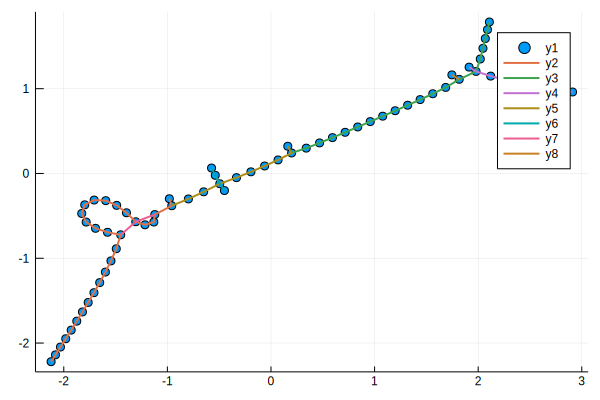

In [243]:
fig = plot()
scatter!(coords[:, 1], coords[:, 2], linewidth=2)
for chain in graph
    idx = [nodes_index[n] for n in chain]
    plot!(coords[idx, 1], coords[idx, 2], linewidth=2)
    #println(coords[idx, 1])
    end;
fig